### 0. Install necessary packages

In [33]:
import preprocessing, models, evaluation
from importlib import reload
reload(models)
reload(preprocessing)
reload(evaluation)

from preprocessing import Preprocess
from models import OgModel, AttModel
from evaluation import EvaluateModel, ExplainModel


### 1. Load the data

In [2]:
X_train, y_train, X_val, y_val, X_test, y_test, m, s = Preprocess(time_steps=5, start_year=2000, save=False)

--- Preprocessing ---
Remove low yield observations:  2
of years:  [1988. 2003.]
Full train data available:  (24311, 393)
Train data used: (10707, 397), starting from year 2000.
- Preprocessed data -
Train data (10707, 397)
Validation data (560, 397)
Test data (472, 397)
Test data has mean 1.5 and std 0.99.



### 2. Set hyperparameters

In [5]:
epochs = 7
learning_rate = 0.0003        # Learning rate

# LSTM parameters
time_steps = 5                # Number of time steps for the RNN
num_units = 64                # Number of hidden units for LSTM cells
num_layers = 2                # Number of layers of LSTM cell
dropout = 0.3                 # Dropout rate

# Attention parameters
num_heads = 4
key_dim = 32

### 3.1 Original Model

In [4]:
ogmodel = OgModel(learning_rate, time_steps, num_units, num_layers, dropout)
ogmodel.compile()

2024-12-11 18:31:40.647140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-11 18:31:40.647468: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...



--- Model Architecture ---
 - CNN for Weather data - 
Output W-CNN: (None, 66)
 - CNN for Soil data - 
Output S-CNN: (None, 44)
 - Concatenate weather, soil and management data - 
W+S+M concatenated: (None, 124)
W+S+M after Dense: (None, 64)
 - LSTM for yield data - 
LSTM output: (None, 64)
 - Combine static and dynamic features - 
Combined: (None, 128)
Combined Dense: (None, 16)
Output: (None, 1) 

Total parameters: 112659


In [6]:
ogmodel.fit_wrapper(X_train, y_train, X_val, y_val, epochs)

Epoch 1/7
335/335 [==============================] - 13s 16ms/step - loss: 0.7301 - val_loss: 0.3655 - lr: 6.0000e-04
Epoch 2/7
335/335 [==============================] - 4s 11ms/step - loss: 0.2880 - val_loss: 0.2639 - lr: 6.0000e-04
Epoch 3/7
335/335 [==============================] - 4s 11ms/step - loss: 0.2095 - val_loss: 0.2396 - lr: 6.0000e-04
Epoch 4/7
335/335 [==============================] - 4s 11ms/step - loss: 0.1745 - val_loss: 0.1728 - lr: 6.0000e-04
Epoch 5/7
335/335 [==============================] - 4s 11ms/step - loss: 0.1555 - val_loss: 0.1809 - lr: 6.0000e-04
Epoch 6/7
335/335 [==============================] - 4s 12ms/step - loss: 0.1416 - val_loss: 0.2000 - lr: 6.0000e-04
Epoch 7/7
335/335 [==============================] - 4s 12ms/step - loss: 0.1331 - val_loss: 0.1623 - lr: 6.0000e-04


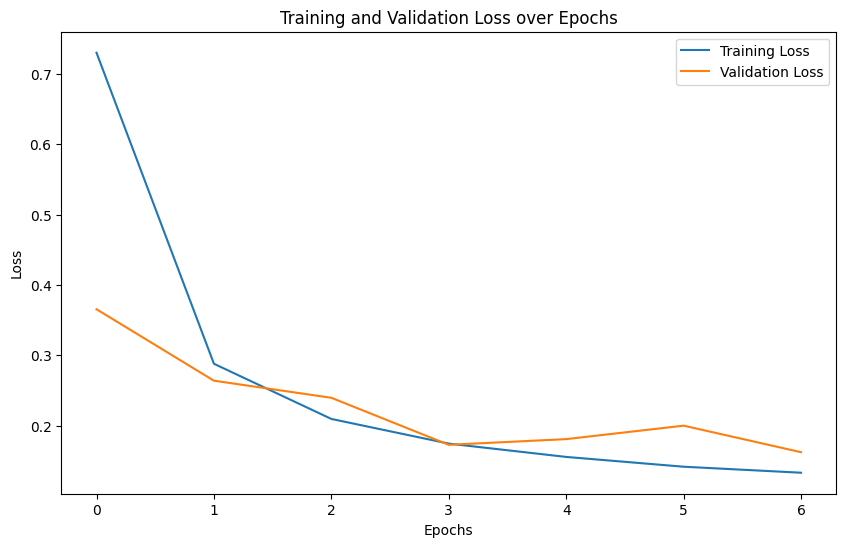

In [7]:
ogmodel.plot_training_history()

18/18 [==============================] - 0s 4ms/step
Training RMSE: 4.365429777093341
Validation RMSE: 5.293091979218412 

Training MAE: 3.2406694914052787
Validation MAE: 4.1723170709609985 

Training R²: 0.8394006477595579
Validation R²: 0.68322389277983


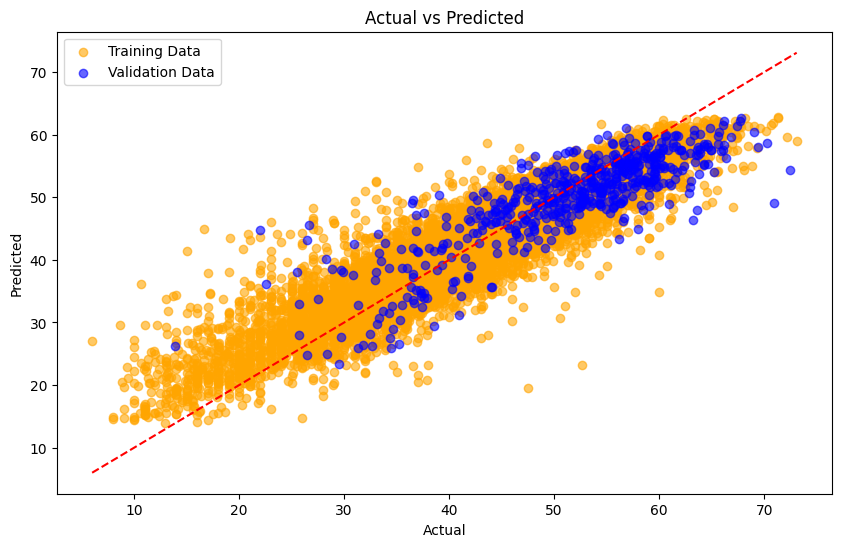

In [8]:
og_evaluator = EvaluateModel(ogmodel, X_train, y_train, X_val, y_val, s, m)
og_evaluator.evaluate()

### 3.2 Attention Model

In [10]:
attmodel = AttModel(learning_rate, time_steps, num_units, num_layers, dropout, num_heads, key_dim)
attmodel.compile()


--- Model Architecture ---
 - CNN for Weather data - 
Output W-CNN: (None, 66)
 - CNN for Soil data - 
Output S-CNN: (None, 44)
 - Concatenate weather, soil and management data - 
W+S+M concatenated: (None, 124)
W+S+M after Dense: (None, 64)
 - LSTM for yield data - 
LSTM output: (None, 64)
 - Combine static and dynamic features - 
Combined: (None, 128)
Combined Dense: (None, 16)
Output: (None, 1) 

Total parameters: 118041


In [11]:
attmodel.fit(X_train, y_train, X_val, y_val, epochs=3)

Epoch 1/3


ValueError: in user code:

    File "/home/jpubu/Master/Applied-Deep-Learning/Project/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/home/jpubu/Master/Applied-Deep-Learning/Project/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jpubu/Master/Applied-Deep-Learning/Project/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/home/jpubu/Master/Applied-Deep-Learning/Project/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/home/jpubu/Master/Applied-Deep-Learning/Project/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jpubu/Master/Applied-Deep-Learning/Project/venv/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_35" expects 19 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 397) dtype=float32>]


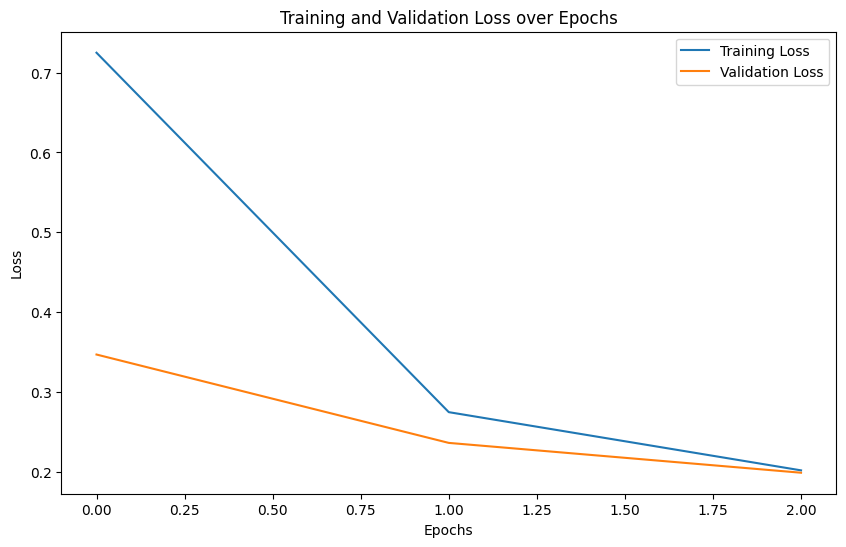

In [155]:
attmodel.plot_training_history()

335/335 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


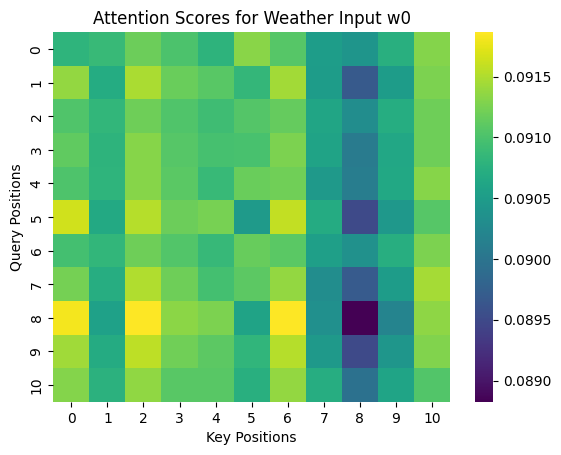

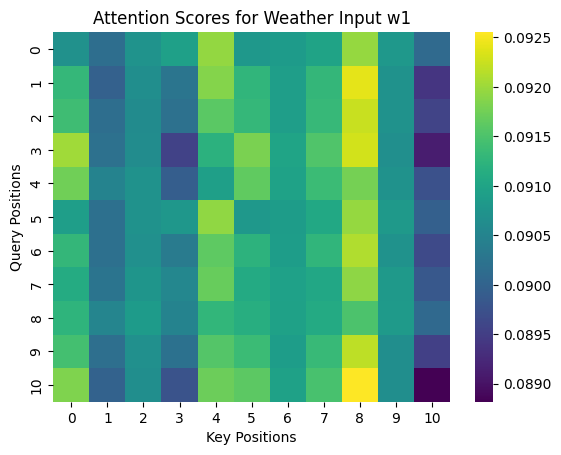

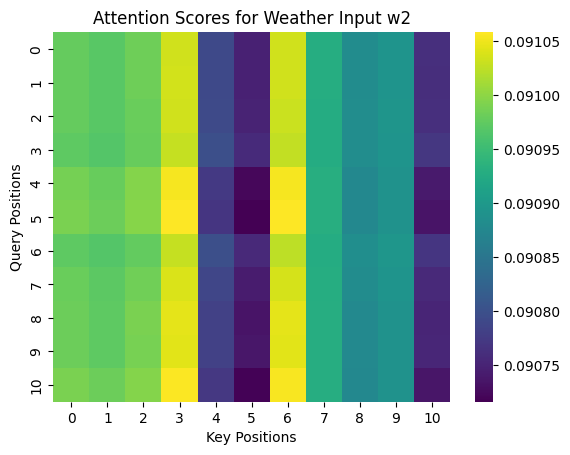

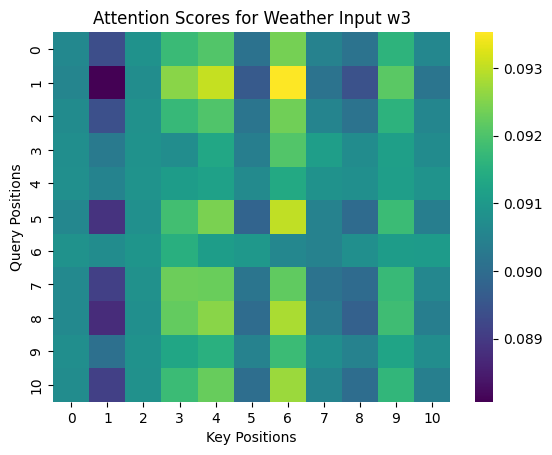

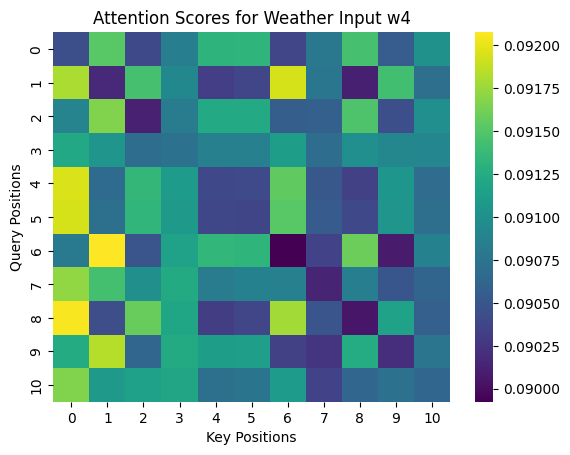

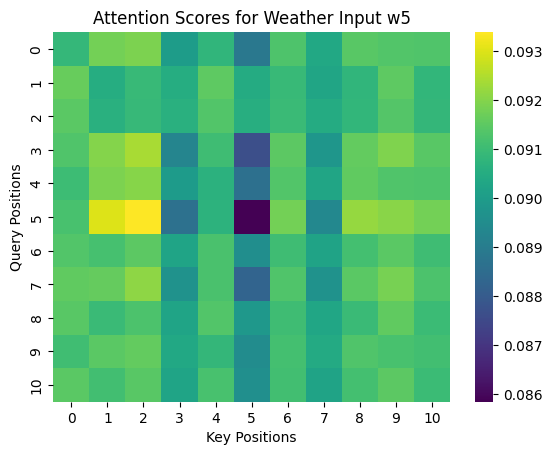

In [ ]:
attmodel.visualize_attention(X_train, 'weather')

335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Training RMSE: 4.7623988948427
Validation RMSE: 7.264384194381387 

Training MAE: 3.5973155035258557
Validation MAE: 6.0124851711954275 

Training R²: 0.808864518998723
Validation R²: 0.4033341999900888


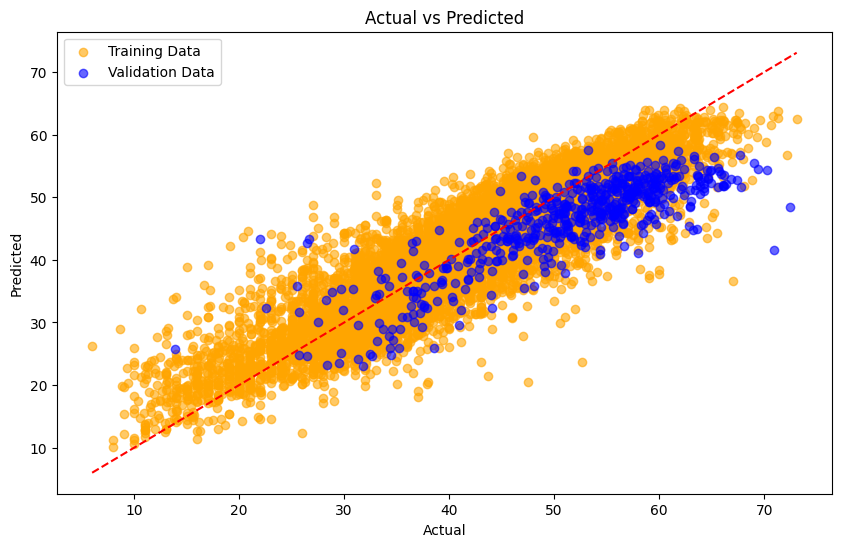

In [ ]:
att_evaluator = EvaluateModel(attmodel, X_train, y_train, X_val, y_val, s, m)
att_evaluator.evaluate()

### 4. Explainability

In [34]:
explainer = ExplainModel(ogmodel, X_train, s, m, time_steps)

In [35]:
explainer.explain_observation(X_val, index = 10, top = 5, show_table=True)

157/157 [==============================] - 1s 4ms/step
Intercept -7.515345023484252
Prediction_local [-7.25390463]
Right: 1.9342092


[('M2 <= 33.17', -5.764997276441074),
 ('M5 <= 31.98', -3.217935842937003),
 ('max temp_32 <= 31.56', 3.0916808096083983),
 ('max temp_35 <= 31.85', 3.0879321480945747),
 ('max temp_34 <= 30.23', 3.0647605525856467)]

In [37]:
indices = [i+30 for i in range(10)]
explainer.explain_many_observations(X_val, indices, top = 10)

157/157 [==============================] - 1s 4ms/step
Intercept -2.950375128670972
Prediction_local [-3.6147936]
Right: 1.8407731
157/157 [==============================] - 1s 4ms/step
Intercept 3.5748735963431066
Prediction_local [-4.15050377]
Right: 1.9038125
157/157 [==============================] - 1s 4ms/step
Intercept 2.817375010215363
Prediction_local [-4.26668725]
Right: 1.9040364
157/157 [==============================] - 1s 4ms/step
Intercept -0.3567499231647435
Prediction_local [-3.08484522]
Right: 1.6466987
157/157 [==============================] - 1s 4ms/step
Intercept 0.9652274877327827
Prediction_local [-4.44017531]
Right: 0.62080586
157/157 [==============================] - 1s 4ms/step
Intercept -0.3311250829771417
Prediction_local [-3.97505132]
Right: 1.2305176
157/157 [==============================] - 1s 4ms/step
Intercept -3.4317269652523894
Prediction_local [-5.30663188]
Right: 0.6677932
157/157 [==============================] - 1s 4ms/step
Intercept 3.5424636

[('max temp_35 <= 31.85', 31.350968433757494),
 ('max temp_32 <= 31.56', 30.41672233104002),
 ('max temp_34 <= 30.23', 28.96414145730892),
 ('clay_100-120 <= 31.02', 22.867181525444394),
 ('max temp_31 <= 31.26', 21.205907754362563),
 ('snow-water-equivalent_22 <= 37.77', 11.338200342023828),
 ('max temp_33 <= 29.37', 5.031905041149887),
 ('bulk density_60-100 <= 29.60', 4.916029446019465),
 ('snow-water-equivalent_23 <= 37.84', 4.326667824361773),
 ('snow-water-equivalent_21 <= 37.59', 2.715455118564995)]